In [1]:
import statistics
import time
import torch
import tqdm
import torch.utils.data as data
import torchvision

from matplotlib import pyplot as plt
from statistics import mean
from torch import nn, optim
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, datasets
from PIL import Image

# Generator
* Output image size is 64 x 64.
* 4 CNN layers.
* In each CNN layers, Transpose Convolution is used.

## ConvTranspose2d parameters
* in_channel
* out_channel
* kernel_size
* stride
* padding

## How Transpose Convolution works.
* https://lhopital.hatenablog.com/entry/2020/10/24/081133#%E3%82%B9%E3%83%88%E3%83%A9%E3%82%A4%E3%83%89-1
* https://github.com/vdumoulin/conv_arithmetic

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

# Generator Operation Check
* input_z.shape: torch.Size([1, 20, 1, 1])
* layer1_output.shape: torch.Size([1, 512, 4, 4])
* layer2_output.shape: torch.Size([1, 256, 8, 8])
* layer3_output.shape: torch.Size([1, 128, 16, 16])
* layer4_output.shape: torch.Size([1, 64, 32, 32])
* last_output.shape: torch.Size([1, 1, 64, 64])

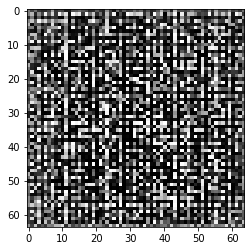

In [3]:
G = Generator(z_dim=20, image_size=64)
input_z = torch.randn(1, 20)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()

plt.imshow(img_transformed, cmap='gray')
plt.show()

# Discriminator
* Applys CNN layer 5 times, then applys sigmoid activation function.
* input.shape: torch.Size([1, 1, 64, 64])
* output.shape: torch.Size([1, 1, 1, 1])

In [4]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size * 2, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size * 4, image_size * 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.last = nn.Conv2d(image_size * 8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

# Descriminator Operation Check

In [5]:
D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_image = G(input_z)

d_out = D(fake_image)

#print(nn.Sigmoid()(d_out))
print(nn.Sigmoid()(d_out))

tensor([[[[0.4990]]]], grad_fn=<SigmoidBackward>)


# Initialize Weight 

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

# Dataloader

In [7]:
transform = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))]
)

trainset = torchvision.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
print(len(trainloader))

118


In [9]:
batch_iterator = iter(trainloader)
images, labels = next(batch_iterator)
print(images.size())

torch.Size([512, 1, 64, 64])


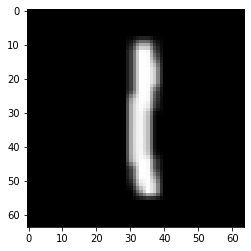

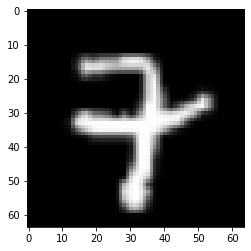

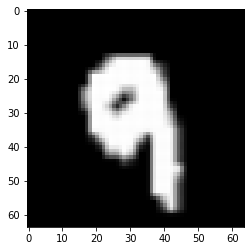

In [10]:
plt.imshow(images[0].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
plt.show()

plt.imshow(images[1].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
plt.show()

plt.imshow(images[2].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
plt.show()

In [22]:
def train_model(G, D, dataloader, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    z_dim = 20
    mini_batch_size  = 512
    
    D.to(device)
    G.to(device)
    
    D.train()
    G.train()
    
    torch.backends.cudnn.benchmark = True
    
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    iteration = 1
    logs = []
    
    d_loss_history = []
    g_loss_history = []
      
    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        
        log_loss_G = list()
        log_loss_D = list()

        if epoch % 30 == 0:
            print('-------------')
            print('Epoch {}/{}'.format(epoch, num_epochs))
            print('-------------')
            print('（train）')

        for imges , _ in trainloader:
            # pass batch_normalization error when batch_size == 1.
            if imges.size()[0] == 1:
                continue

            # train descriminator
            imges = imges.to(device)

            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            d_out_real = D(imges)

            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # train generator 
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            g_loss = criterion(d_out_fake.view(-1), label_real)

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # Combination of list and statistics.mean is the best coding style I have ever seen!
            log_loss_G.append(g_loss.item())
            log_loss_D.append(d_loss.item())
            iteration += 1
            
        d_loss_history.append(statistics.mean(log_loss_G))
        g_loss_history.append(statistics.mean(log_loss_D))

        t_epoch_finish = time.time()
        if epoch % 30 == 0:
            print('-------------')
            print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(epoch, statistics.mean(log_loss_G), statistics.mean(log_loss_D)))
            print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
            t_epoch_start = time.time()

    return G, D, d_loss_history, g_loss_history

In [23]:
num_epochs  = 300
G_update, D_update , d_loss_history, g_loss_history = train_model(G, D, dataloader=trainloader, num_epochs=num_epochs)

cuda:0
-------------
Epoch 0/300
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:3.9217 ||Epoch_G_Loss:0.3214
timer:  26.7005 sec.
-------------
Epoch 30/300
-------------
（train）
-------------
epoch 30 || Epoch_D_Loss:3.4188 ||Epoch_G_Loss:0.4053
timer:  28.1980 sec.
-------------
Epoch 60/300
-------------
（train）
-------------
epoch 60 || Epoch_D_Loss:3.8788 ||Epoch_G_Loss:0.3351
timer:  28.2067 sec.
-------------
Epoch 90/300
-------------
（train）
-------------
epoch 90 || Epoch_D_Loss:3.5906 ||Epoch_G_Loss:0.4551
timer:  28.2009 sec.
-------------
Epoch 120/300
-------------
（train）
-------------
epoch 120 || Epoch_D_Loss:4.9263 ||Epoch_G_Loss:0.2381
timer:  28.2088 sec.
-------------
Epoch 150/300
-------------
（train）
-------------
epoch 150 || Epoch_D_Loss:6.2816 ||Epoch_G_Loss:0.0630
timer:  28.1726 sec.
-------------
Epoch 180/300
-------------
（train）
-------------
epoch 180 || Epoch_D_Loss:3.9051 ||Epoch_G_Loss:0.2876
timer:  28.1889 sec.
-------------
Epoch 210

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (300,) and (100,)

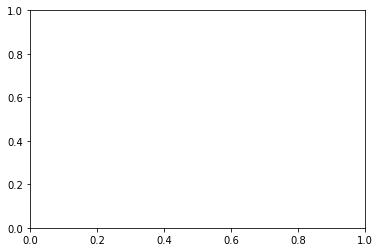

In [24]:
plt.figure()
plt.plot(range(1, num_epochs+1), d_loss_history, label='descriminator_loss')
plt.xlabel('epoch')
plt.legend()

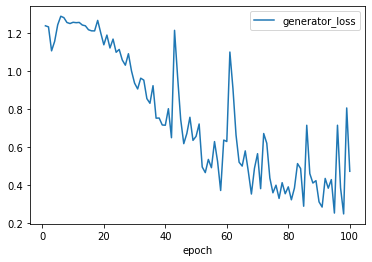

In [19]:
plt.figure()
plt.plot(range(1, num_epochs+1), g_loss_history, label='generator_loss')
plt.xlabel('epoch')
plt.legend()

# Visulalize Result
* Fake images are Only "1" .
* This is  the **Mode collapse** .
* Below link shows a good case in MNIST, but parameters of D and G are different.
* https://blog.shikoan.com/pytorch-dcgan/
* Detailed description about  **Mode collapse** is below link.
* https://qiita.com/triwave33/items/a5b3007d31d28bc445c2

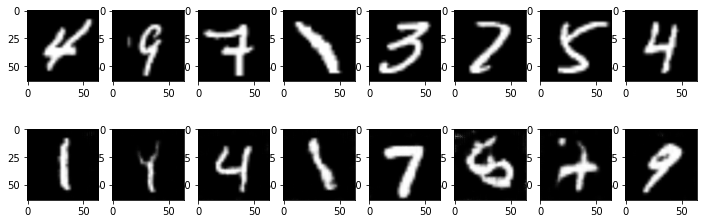

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Input random param
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

G_update.eval()
fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(trainloader)
imges, _ = next(batch_iterator)

fig = plt.figure(figsize=(12, 4))
for i in range(0, 8):
    plt.subplot(2, 8, i+1)
        
    plt.imshow(imges[i].cpu().detach().numpy().transpose(1, 2, 0)[:, :, 0], 'gray')
    
    plt.subplot(2, 8, 8+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')